<a href="https://colab.research.google.com/github/menamerai/vssr-2020/blob/master/Brazilian_House_Rent_Price(final_submission).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazilian House Rent Price

After taking a look at the data, I've decided that the houses_to_rentv1 is pretty much unusable for me. So I'll use the v2, and decide to predict the most useful-looking value: Rent amount

# Setup

Setup time. We load all of the necessary libraries and the data.

In [88]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [89]:
# Import the scikit-learn methods and models here
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [90]:
data = pd.read_csv("https://raw.githubusercontent.com/menamerai/vssr-2020/master/datasets_554905_1035602_houses_to_rent_v2.csv").drop(["total (R$)"], axis=1)
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11


# Data Inference

Now we'll look at the raw data, and use statistical methods and analysis to infer meaning and decide what to visualize, and what to use for the ML process.

In [91]:
X_labels = ["city", "area", "rooms", "bathroom", "parking spaces", "floor", "animal", "furniture", "hoa (R$)", "fire insurance (R$)", "property tax (R$)"]
X = data[X_labels]
y = data["rent amount (R$)"]

In [92]:
data.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000


> By Phan Anh

We can see that the money is in Brazilian Real. 1 Real ~ 4.3k VND, so 450 Real, the lowest rent cost ~ 1.9mil VND, and the highest rent, 45000 Real ~ 196mil VND (which is ridiculous).

In [93]:
data.groupby(["city"]).mean()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
city,,,,,,,,
Belo Horizonte,207.411765,3.020668,2.402226,1.955485,2324.197138,3664.127981,272.782194,53.675676
Campinas,137.561547,2.355217,1.960141,1.558030,628.922626,2364.290739,147.657679,32.388042
Porto Alegre,103.609388,2.140821,1.725901,1.044426,491.618609,2337.699916,124.021794,36.425817
Rio de Janeiro,105.347768,2.243837,1.756163,0.744171,1079.432378,3232.904064,256.853431,42.483011
São Paulo,158.899439,2.558859,2.467641,1.877527,1169.627994,4652.793783,495.701716,62.428911




> By Phan Anh

I decided to analyze a bit further into the state of being furnished, and whether the rental house allows pet.


In [94]:
data.groupby(["furniture", "city"])["rent amount (R$)"].agg([len, min, median, max, mean]) # Anh

len  min  median    max         mean
furniture     city                                                 
furnished     Belo Horizonte   177  700    3300  15000  4756.994350
              Campinas         111  500    2200  13500  2889.648649
              Porto Alegre     319  550    2200  14000  3026.949843
              Rio de Janeiro   406  750    3000  15000  4227.091133
              São Paulo       1593  600    4280  20000  5573.575016
not furnished Belo Horizonte  1081  450    2150  15000  3485.185014
              Campinas         742  500    1400  15000  2285.699461
              Porto Alegre     874  500    1500  19000  2086.131579
              Rio de Janeiro  1095  500    2000  15000  2864.283105
              São Paulo       4294  500    3000  45000  4311.199814

> By Phan Anh

There is a **very** clear trend that suggests furnished houses costs more on every city, which makes sense in real life.

In [95]:
data.groupby(["animal", "city"])["rent amount (R$)"].agg([len, min, median, max, mean]) # Anh

len  min  median    max         mean
animal    city                                                 
acept     Belo Horizonte   931  450  2500.0  15000  3874.740064
          Campinas         693  500  1590.0  15000  2462.653680
          Porto Alegre    1005  500  1632.0  19000  2347.650746
          Rio de Janeiro  1205  500  2300.0  15000  3255.862241
          São Paulo       4482  550  3505.0  45000  4870.817046
not acept Belo Horizonte   327  460  1633.0  15000  3064.495413
          Campinas         160  500  1186.5  15000  1938.256250
          Porto Alegre     188  500  1700.0  15000  2284.505319
          Rio de Janeiro   296  505  2500.0  15000  3139.442568
          São Paulo       1405  500  2900.0  20000  3957.291815

> By Phan Anh

The trend is less noticeable here, but present. What is interesting is that in Porto Alegre and Rio de Janeiro, the trend appears to be less prominent with only ~100$R in difference.

> By Phan Anh

<b><h2>Conclusion:</h2></b> So we see that by itself, <b>city </b> is not a very useful column, but when paired with other columns, as demonstrated in the case of <b>animal and furniture</b>, it suggests a strong dormant trend, and help in predicting (Porto Alegre and Rio both differ little from rent price whether they allow pets or not. So, we should only use city in conjunction with other columns if possible.

# Data Visualization

We begin with general and mass visualization, then move on to more specific cases and pairs

## Mass Visualization

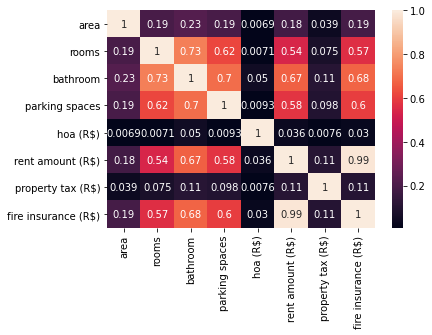

In [96]:
sns.heatmap(data.corr(), annot=True)

Hmm... It seems that the homeowner tax and the property tax has little to do with anything else, creating a clear black mark. I'll drop them.

In [97]:
X = X.drop(["hoa (R$)", "property tax (R$)"], axis=1)
X.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,fire insurance (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,42
1,São Paulo,320,4,4,0,20,acept,not furnished,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,41
3,Porto Alegre,51,2,1,0,2,acept,not furnished,17
4,São Paulo,25,1,1,0,1,not acept,not furnished,11


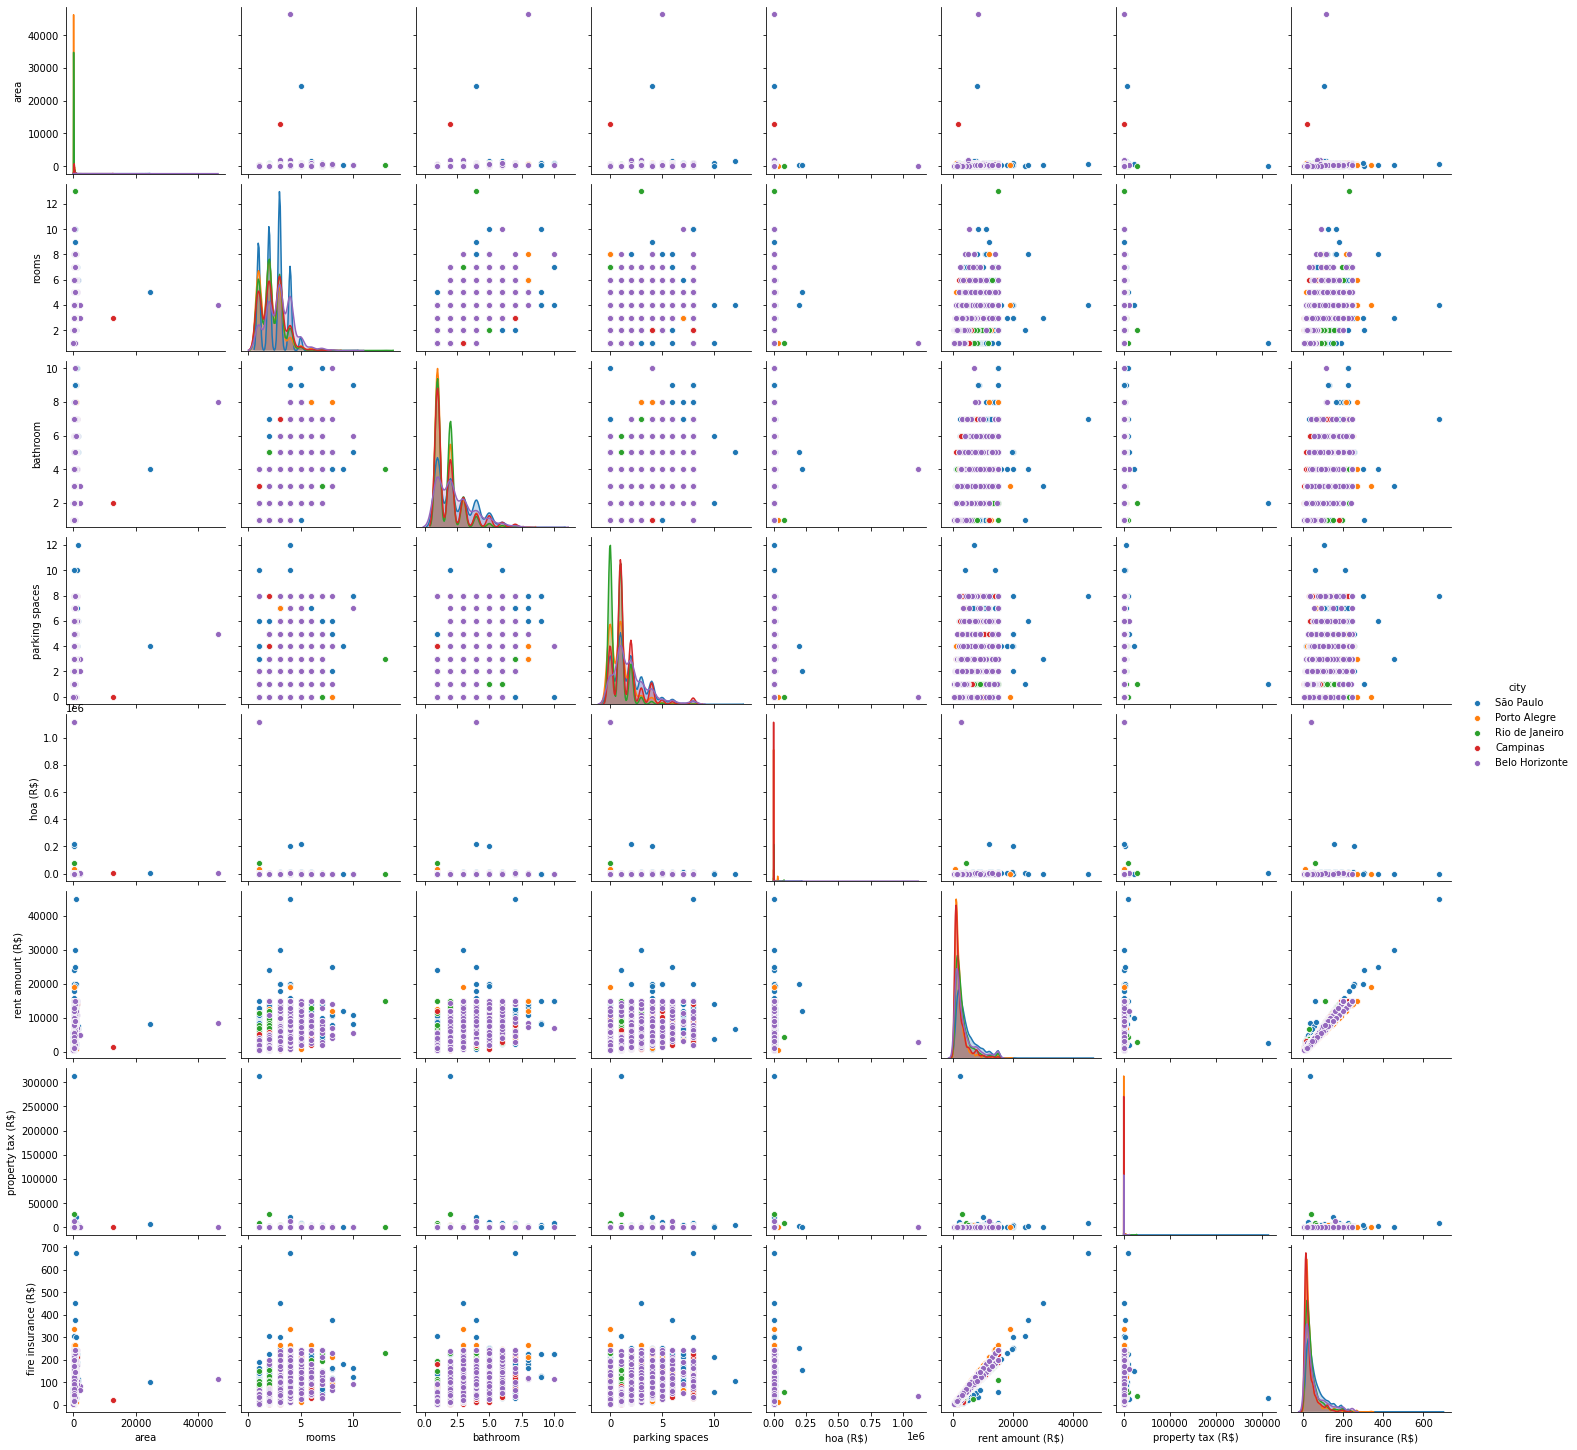

In [98]:
sns.pairplot(data=data, hue="city")

## Detailed Visualization


> By Phan Anh

We saw a pretty interesting correlation in the pairplot, being fire insurance price and the actual rent amount. We'll look further into it.

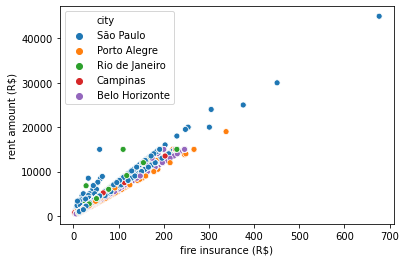

In [99]:
sns.scatterplot(data=data, x="fire insurance (R$)", y="rent amount (R$)", hue="city") # Anh

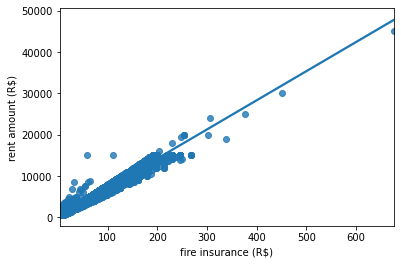

In [100]:
sns.regplot(data=data, x="fire insurance (R$)", y="rent amount (R$)") # Anh

> By Phan Anh

Would you look at that, the regression line is super neat. This confirms my suspicion. Not convinced? Well...

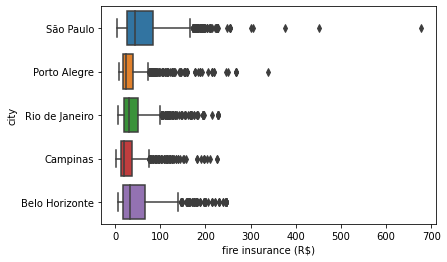

In [101]:
sns.boxplot(data=data, x="fire insurance (R$)", y="city") # Anh

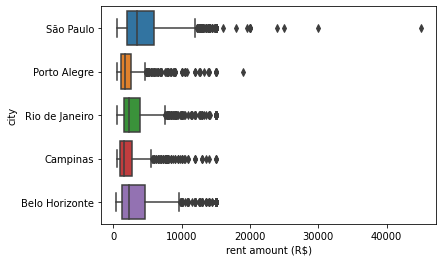

In [102]:
sns.boxplot(data=data, x="rent amount (R$)", y="city") # Anh

> By Phan Anh

The former boxplot depicts the fire insurance, and the latter depicts rent amount. Could you tell by a glance that these two are completely different plots from your first try? I don't think so. Even though the x axis is different in value, they still quite neatly line up with each other. It is confirmed that these two share quite a correlation with each other.

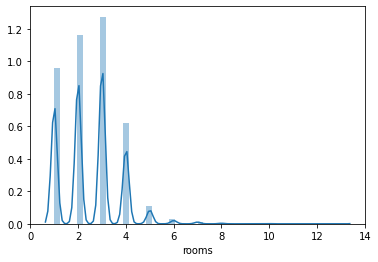

In [103]:
sns.distplot(X["rooms"]) # Anh

> By Phan Anh

So we can see that most houses have 1,2,3,4 or even 5 rooms...

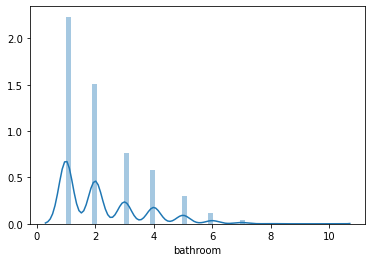

In [104]:
sns.distplot(X["bathroom"]) # Anh

> By Phan Anh

... while somehow, bathrooms have a more diverse range of 1-6.

**Suggestion:** we could make every value of room that is > 5, and value of bathroom > 6, to a fixed value, like 6 and 7 respectively. Though if there is any correlation between room, bathroom and rent price, we'll have to watch out. Let's see if there is one first. 

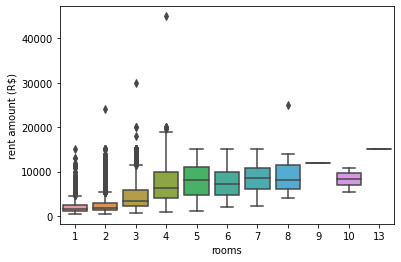

In [105]:
sns.boxplot(data=data, x="rooms", y="rent amount (R$)") # Anh

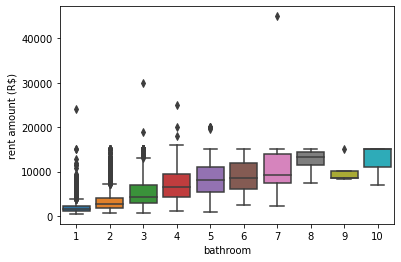

In [106]:
sns.boxplot(data=data, x="bathroom", y="rent amount (R$)") # Anh

> By Phan Anh

On second thought, I don't think I want to do that, doing that will erase the diversity in the relationship between the rooms (assuming there is any). I also tried a room-to-bathroom ratio, but it did not perform well.

# Data Manipulation

Time to change up the data a bit so the model can better infer from it. First step is to convert every string value to integers.

In [107]:
print(X["city"].unique())
print(X["animal"].unique())
print(X["furniture"].unique())

['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte']
['acept' 'not acept']
['furnished' 'not furnished']


In [108]:
print(X["floor"].unique())
# I checked the other columns. Seems to be all fine

['7' '20' '6' '2' '1' '-' '4' '3' '10' '11' '24' '9' '8' '17' '18' '5'
 '13' '15' '16' '14' '26' '12' '21' '19' '22' '27' '23' '35' '25' '46'
 '28' '29' '301' '51' '32']


There are 5 unique cities, so it should work ok.
* Sao Paulo = 1
* Porto Alegre = 2
* Rio = 3
* Campinas = 4
* Belo Horizonte = 5

There are also two different values in the animal column and the furniture column, and the "-" thing in the floor. I will assume it means no data and drop the columns with it.

In [109]:
# Run this only once, please
X["city"] = X["city"].apply(lambda x: 1 if x == "São Paulo" 
                            else 2 if x == "Porto Alegre" 
                            else 3 if x == "Rio de Janeiro"
                            else 4 if x =="Campinas" else 5)
X["animal"] = X["animal"].apply(lambda x: 1 if x == "acept" else 0) # Gosh the hell is acept
X["furniture"] = X["furniture"].apply(lambda x: 1 if x == "furnished" else 0)
X["floor"] = X["floor"].apply(lambda x: np.nan if x == "-" else x)

In [110]:
X.tail()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,fire insurance (R$)
10687,2,63,2,1,1,5,0,1,22
10688,1,285,4,4,4,17,1,0,191
10689,3,70,3,3,0,8,0,1,78
10690,3,120,2,2,2,8,1,1,155
10691,1,80,2,1,0,NaN,1,0,22


In [111]:
y.tail()

10687     1478
10688    15000
10689     6000
10690    12000
10691     1400
Name: rent amount (R$), dtype: int64

... and all done! Now the fun part.

# Machine Learning

## General Models

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
print("There are {} samples in the training set and {} samples in the test set".format(X_train.shape[0], X_test.shape[0]))

There are 8553 samples in the training set and 2139 samples in the test set


This was the place for gridsearch. Now I no longer needs this because I've got the best parameters via this, and self experimentation.

In [113]:
"""
pipeline = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1))])
grid_params = {
    "model__n_estimators": [140, 160, 180],
    "model__criterion": ["mse"],
    "model__bootstrap": [False],
    "model__max_depth": list(range(5, 21, 5))
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=3, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_params_
"""

'\npipeline = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),\n                            ("model", RandomForestRegressor(random_state=1))])\ngrid_params = {\n    "model__n_estimators": [140, 160, 180],\n    "model__criterion": ["mse"],\n    "model__bootstrap": [False],\n    "model__max_depth": list(range(5, 21, 5))\n}\ngrid_search = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=3, verbose=1)\ngrid_search.fit(X_train, y_train)\ngrid_search.best_params_\n'

### Mean Squared Error Model

In [114]:
final_model = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mse",
                                                            n_estimators=180,
                                                            max_depth=7))])
scores = cross_validate(final_model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-scores["test_score"].mean())

384.1217754537035


### Mean Absolute Error Model

In [115]:
final_model_mae = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mae",
                                                            n_estimators=60,
                                                            max_depth=16))])
scores_mae = cross_validate(final_model_mae, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
print(-scores_mae["test_score"].mean())

121.42491913168868


### Mini Model 

This predicts the rent price using fire insurance price, and the location of the place.

446.17659375623003


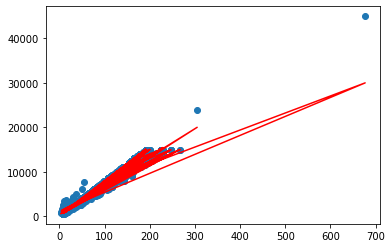

In [116]:
final_model_mse_fire = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mse",
                                                            n_estimators=100,
                                                            max_depth=15))])
scores_mse_fire = cross_validate(final_model_mse_fire, X_train[["fire insurance (R$)"]], y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-scores_mse_fire["test_score"].mean())
# Anh
plt.scatter(X_test[["fire insurance (R$)"]], y_test, label="Data")
final_model_mse_fire.fit(X_train[["fire insurance (R$)"]], y_train)
mse_preds = final_model_mse_fire.predict(X_test[["fire insurance (R$)"]])
plt.plot(X_test[["fire insurance (R$)"]], mse_preds, color="red", label="Model")

> Everything beyond this point is by Phan Anh

## Specific Models

### Linear Regression model

Seeing how fire insurance linearly correlate to rent amount, I want to see how a simpler model could perform.

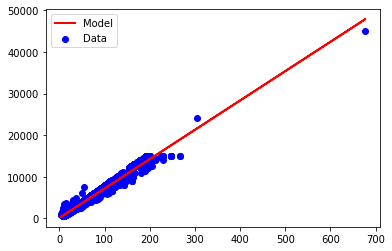

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                      ("model", LinearRegression())])

lr.fit(X_train[["fire insurance (R$)"]], y_train)
y_preds = lr.predict(X_test[["fire insurance (R$)"]])

plt.scatter(X_test["fire insurance (R$)"], y_test, color="blue", label="Data")
plt.plot(X_test["fire insurance (R$)"], y_preds, color="red", linewidth=2, label="Model")
plt.legend()

In [118]:
mean_absolute_error(y_test, y_preds)

343.74983786557544

... it performed much better than the RandomForest models, except for the, well MAE model. It is exciting to see that even a simple Regression models perform really well on such datasets. However, this is of little practical uses.

### GradientBoostingRegressor
This is RandomForest combined with Gradient Boosting from a loss function.

In [119]:
from sklearn.ensemble import GradientBoostingRegressor
"""
gbr_pipeline = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", GradientBoostingRegressor(random_state=1,
                                                                max_depth=5))])
gbr_grid_params = {
    "model__criterion": ["mse", "friedman_mse", "mae"],
    "model__loss": ["ls", "lad", "huber", "quantile"]
}
gbr_grid_search = GridSearchCV(estimator=gbr_pipeline, param_grid=gbr_grid_params, cv=3, verbose=1)
gbr_grid_search.fit(X_train, y_train)
gbr_grid_search.best_params_
"""

'\ngbr_pipeline = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),\n                            ("model", GradientBoostingRegressor(random_state=1,\n                                                                max_depth=5))])\ngbr_grid_params = {\n    "model__criterion": ["mse", "friedman_mse", "mae"],\n    "model__loss": ["ls", "lad", "huber", "quantile"]\n}\ngbr_grid_search = GridSearchCV(estimator=gbr_pipeline, param_grid=gbr_grid_params, cv=3, verbose=1)\ngbr_grid_search.fit(X_train, y_train)\ngbr_grid_search.best_params_\n'

In [120]:
gbr = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                      ("model", GradientBoostingRegressor(random_state=1,
                                                          max_depth=5))])

gbr_scores = cross_validate(gbr, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-gbr_scores["test_score"].mean())

314.74878785646496


Wow... This model is much better! And it's better with much less estimators and depth as well!

## Meaningful Models

Let's try something more practical, let's say we'll predict the rent prices based on: city, area, room, bathroom, floor, parking spaces, whether they allow pets, and whether the room is furnished.

### RandomForest

In [121]:
meaningful_rf = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mae",
                                                            n_estimators=50,
                                                            max_depth=7))])
meaningful_scores = cross_validate(meaningful_rf, X_train[["area", "rooms", "bathroom", "floor", "parking spaces", "animal", "furniture", "city"]], y_train, cv=3, scoring="neg_mean_absolute_error")
print(-meaningful_scores["test_score"].mean())

1426.1616719279784


So we can see that things that are meaningful tend to not perform well in the real world. Maybe I'll see what I can do with other models.

### GradientBoostingRegressor

In [122]:
meaningful_gbr = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                      ("model", GradientBoostingRegressor(random_state=1,
                                                          max_depth=5,))])

meaningful_gbr_scores = cross_validate(meaningful_gbr, X_train[["area", "rooms", "bathroom", "floor", "parking spaces", "animal", "furniture", "city"]], y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-meaningful_gbr_scores["test_score"].mean())

2166.9791259255335


Nope. Not even with GBR, and it performed even worse than normal RandomForest. Wait... If more advanced models performed worse... then what about simpler ones? DecisionTree?

### DecisionTree

In [123]:
from sklearn.tree import DecisionTreeRegressor

meaningful_dt = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                      ("model", DecisionTreeRegressor(random_state=1,
                                                      criterion="friedman_mse",
                                                      max_depth=4))])

meaningful_dt_scores = cross_validate(meaningful_dt, X_train[["area", "rooms", "bathroom", "floor", "parking spaces", "animal", "furniture", "city"]], y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-meaningful_dt_scores["test_score"].mean())

2286.9510539212556


Huh... This performed a bit better than I thought. Anyhow that's nowhere near applicable in real life... None of these are.

**Time for the big gun.**

### XGBoost

In [124]:
from xgboost import XGBRegressor
"""
xgboost_grid = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                      ("model", XGBRegressor(random_state=1, n_estimators=300))])
xgboost_params = {
    "model__max_depth": [3, 6, 10, 15],
    "model__learning_rate": [0.05, 0.1, 0.3, 0.6]
}

xgboost_grid_search = GridSearchCV(estimator=xgboost_grid, param_grid=xgboost_params, cv=3, verbose=1)
xgboost_grid_search.fit(X_train, y_train)
xgboost_grid_search.best_params_
"""

'\nxgboost_grid = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),\n                      ("model", XGBRegressor(random_state=1, n_estimators=300))])\nxgboost_params = {\n    "model__max_depth": [3, 6, 10, 15],\n    "model__learning_rate": [0.05, 0.1, 0.3, 0.6]\n}\n\nxgboost_grid_search = GridSearchCV(estimator=xgboost_grid, param_grid=xgboost_params, cv=3, verbose=1)\nxgboost_grid_search.fit(X_train, y_train)\nxgboost_grid_search.best_params_\n'

In [125]:
xgboost = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                           ("model", XGBRegressor(random_state=1, 
                                                  n_estimators=300,
                                                  learning_rate=0.05,
                                                  max_depth=6,
                                                  verbosity=0))])

xgboost_scores = cross_validate(xgboost, X_train[["area", "rooms", "bathroom", "floor", "parking spaces", "animal", "furniture", "city"]], y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-xgboost_scores["test_score"].mean())

2199.0090027557017


I am aware that XGBoost uses its own training functions and data reading (.train and .DMatrix), but I'll probably not use it, since it'll be a huge hassle, and it's not likely to help. I'd like to try one more thing with XGBoost however...

447.6211371254771


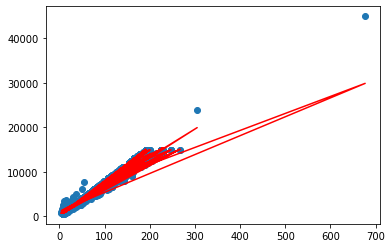

In [126]:
xgboost_fire = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                              ("model", XGBRegressor(random_state=1, 
                                                    n_estimators=300,
                                                    learning_rate=0.03,
                                                    max_depth=6,
                                                    verbosity=0))])

xgboost_scores_fire = cross_validate(xgboost_fire, X_train[["fire insurance (R$)"]], y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-xgboost_scores_fire["test_score"].mean())
plt.scatter(X_test[["fire insurance (R$)"]], y_test, label="Data")
xgboost.fit(X_train[["fire insurance (R$)"]], y_train)
y_xbgoost_preds = xgboost.predict(X_test[["fire insurance (R$)"]])
plt.plot(X_test[["fire insurance (R$)"]], y_xbgoost_preds, color="red", label="Model")

# Conclusion

## General Models

Models that train using all available columns

*   Mean Absolute Error RandomForest: ~530k VND error (very slow)
*   Friedman Squared Error GradientBoostingRegressor: ~1.3mil VND error (very fast)



## Fire Insurance

Models that only train on fire insurance

*   LinearRegression: ~1.5mil VND error (very fast)
*   Mean Squared Error RandomForest: ~1.9mil VND error (quite fast)
*   Also XGBRegressor Tree Booster: ~1.9mil VND error



## Meaningful (not)

Models that train on housing physical values

*   Mean Absolute Error RandomForest: ~6.2mil VND error (slow)
*   Friedman Squared Error GradientBoostingRegressor: ~9.4mil VND error